# Import data

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list --mine

-rw-r--r-- 1 root root 62 Jun 14 19:19 kaggle.json
ref                       title               size  lastUpdated          downloadCount  
------------------------  -----------------  -----  -------------------  -------------  
snv023/ocr-car-numbers    ocr car numbers      6GB  2020-05-17 04:30:41              6  
snv023/generated-numbers  generated_numbers  103MB  2020-06-09 10:58:22              0  


In [ ]:
!kaggle datasets download -d snv023/ocr-car-numbers
!kaggle datasets download -d snv023/generated-numbers

100% 6.04G/6.05G [02:12<00:00, 17.8MB/s]
100% 6.05G/6.05G [02:12<00:00, 49.0MB/s]
 94% 97.0M/103M [00:01<00:00, 53.3MB/s]
100% 103M/103M [00:01<00:00, 72.8MB/s] 


In [ ]:
# it will take arpoximatly 4.5 minutes
!unzip -q "generated-numbers.zip"
!unzip -q "ocr-car-numbers.zip"
!rm *.zip
!rm data/train/25632.bmp

In [ ]:
!ls /content/data/test | wc -l

3188


In [ ]:
!ls /content/data/train | wc -l

25632


In [ ]:
!ls /content/generated_60k | wc -l

59987


In [ ]:
import json
import os

PATH_TO_DATA = 'data'

with open(os.path.join(PATH_TO_DATA, 'train.json'), 'rb') as f:
    j_file = json.load(f)

for row in j_file:
    if row['file'] == 'train/25632.bmp':
        j_file.remove(row)
    row['file'] = os.path.join(PATH_TO_DATA, row['file'])

os.remove(os.path.join(PATH_TO_DATA, 'train.json'))

with open(os.path.join(PATH_TO_DATA, 'train.json'), 'w') as f:
    json.dump(j_file, f)

In [ ]:
j_file[0]

{'file': 'data/train/0.jpg',
 'nums': [{'box': [[180, 889], [596, 951], [598, 1056], [185, 983]],
   'text': 'B060BB125'}]}

# Init const

In [ ]:
import cv2
from matplotlib import pyplot as plt
from matplotlib.path import Path
import seaborn as sns
import os
import numpy as np

import math
import sys
import time
import torch
from tqdm.notebook import tqdm

%matplotlib inline
from IPython.display import clear_output

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Addition functions

In [ ]:
# Бинарный поиск для приближения предсказанной маски 4-хугольником
def simplify_contour(contour, n_corners=4):
    n_iter, max_iter = 0, 1000
    lb, ub = 0., 1.

    while True:
        n_iter += 1
        if n_iter > max_iter:
            print('simplify_contour didnt coverege')
            return None

        k = (lb + ub)/2.
        eps = k*cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, eps, True)

        if len(approx) > n_corners:
            lb = (lb + ub)/2.
        elif len(approx) < n_corners:
            ub = (lb + ub)/2.
        else:
            return approx

# Отображаем 4-хугольник в прямоугольник 
def four_point_transform(image, pts):
    
    rect = order_points(pts)
    
    tl, tr, br, bl = pts
    
    width_1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_1), int(width_2))
    
    height_1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_1), int(height_2))
    
    dst = np.array([
        [0, 0],
        [max_width, 0],
        [max_width, max_height],
        [0, max_height]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect


# Визуализируем детекцию (4 точки, bounding box и приближенный по маске контур)
def visualize_prediction_plate(file, model, device='cuda', verbose=True, thresh=0.0, 
                               n_colors=None, id_to_name=None):
    img = Image.open(file)
    img_tensor = img_transforms(img)
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]
    
    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features
    
    palette = sns.color_palette(None, n_colors)
    
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    image = img
    
    blackImg = np.zeros(image.shape, image.dtype)
    blackImg[:,:] = (0, 0, 0)
    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()
        name = id_to_name[label]
        color = palette[label]
        
        if verbose:
            if score > thresh:
                print ('Class: {}, Confidence: {}'.format(name, score))
        if score > thresh:            
            crop_img = image[y_min:y_max, x_min:x_max]
            print('Bounding box:')
            show_image(crop_img, figsize=(10, 2))
            
            contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]
            
            
            points = np.array(points)
            crop_mask_img = four_point_transform(img, points)
            print('Rotated img:')
            crop_mask_img = cv2.resize(crop_mask_img, (320, 64), interpolation=cv2.INTER_AREA)
            show_image(crop_mask_img, figsize=(10, 2))
            if approx is not None:
                cv2.drawContours(image, [approx], 0, (255,0,255), 3)
            image = cv2.circle(image, (x0, y0), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x1, y1), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x2, y2), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x3, y3), radius=5, color=(0, 0, 255), thickness=-1)
            
            image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), np.array(color) * 255, 2)
            
    show_image(image)
    return prediction

# Просто показать картинку
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()
    

# Переводит предсказания модели в текст
def decode(pred, alphabet):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], alphabet))
    return outputs

def pred_to_string(pred, alphabet):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([alphabet[c] for c in out])
    return out
    

        
def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)
    
# Чтобы без проблем сериализовывать json. Без него есть нюансы
class npEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int32):
            return int(obj)
        return json.JSONEncoder.default(self, obj)

## Vars

In [ ]:
NUM_IMAGES_TO_SHOW = 36
NUM_COLS = 4
NUM_ROWS = NUM_IMAGES_TO_SHOW // NUM_COLS + int(NUM_IMAGES_TO_SHOW % NUM_COLS != 0)
PATH_TO_DATA = 'data'
TRAIN_SIZE = 0.85

image_names = os.listdir('data/train')

In [ ]:
all_marks = load_json(os.path.join(PATH_TO_DATA, 'train.json'))

In [ ]:
import pickle
indices_for_delete = []

bad_files = pickle.load(open("bad_file_names.pkl", 'rb'))

for i in tqdm(range(len(all_marks))):
    for j in range(len(bad_files)):
        if all_marks[i]['file'] == os.path.join(PATH_TO_DATA, bad_files[j]):
            indices_for_delete.append(i)

for ind in sorted(indices_for_delete, reverse=True):
    all_marks.remove(all_marks[ind])

In [ ]:
test_start = int(TRAIN_SIZE * len(all_marks))
train_marks = all_marks[:test_start]
val_marks = all_marks[test_start:]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Visualize data

In [ ]:
test_images = os.listdir('data/test')
random_idxs = np.random.choice(len(test_images), size=min(NUM_IMAGES_TO_SHOW, len(test_images)), replace=False)

plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(random_idxs, 1):
    image = cv2.imread(os.path.join(PATH_TO_DATA, 'test',  test_images[idx]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image)

plt.tight_layout()
plt.show()

In [ ]:
test_images = [dict(file=os.path.join(PATH_TO_DATA, 'test', f)) for f in os.listdir(os.path.join(PATH_TO_DATA, 'test'))]
with open('data/test.json', 'w') as f:
      json.dump(test_images, f)

with open(os.path.join(PATH_TO_DATA, 'test.json'), 'rb') as f:
    j_file_test = json.load(f)

In [ ]:
with open(os.path.join(PATH_TO_DATA, 'train.json'), 'rb') as f:
    j_file = json.load(f)
    
for num in j_file[1]['nums']:
    print(num['box'])

[[794, 661], [1004, 618], [1009, 670], [799, 717]]
[[944, 268], [995, 267], [994, 283], [942, 283]]


In [ ]:
def draw_bbox(idx):
    img = plt.imread(j_file[idx]['file'], 0)
    for num in j_file[idx]['nums']:
        bbox = np.array(num['box'])
        cv2.polylines(img, [bbox], True, (255,0,0), 3)
    return(img)

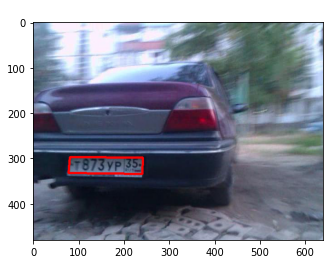

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from PIL import Image
import numpy as np

idx = 2000
img = draw_bbox(idx)
plt.imshow(img)
plt.title(j_file[idx]['nums'][0]['text'], color=(1,1,1))
plt.show();

In [ ]:
def crop_bbox(idx):
    img = plt.imread(j_file[idx]['file'])
    res = []
    for num in j_file[idx]['nums']:

        xmin = min([coord[0] for coord in num['box']])
        xmax = max([coord[0] for coord in num['box']])
        ymin = min([coord[1] for coord in num['box']])
        ymax = max([coord[1] for coord in num['box']])

        height = xmax-xmin
        width = ymax-ymin
        res.append(img[ymin:ymax, xmin:xmax, :])
    return res

In [ ]:
random_idxs = np.random.choice(len(image_names), size=min(NUM_IMAGES_TO_SHOW, len(image_names)), replace=False)
res = {}
plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(random_idxs):
    images = crop_bbox(idx)
    res[idx] = len(images)
    for j, image in enumerate(images, 1):
        plt.subplot(NUM_ROWS * 4, 4, j + (i * 4))
        plt.title(j_file[idx]['nums'][j - 1]['text'], color=(1,1,1))
        plt.imshow(image)

plt.tight_layout()
plt.show()
print(res)

In [ ]:
random_idxs = np.random.choice(len(image_names), size=min(NUM_IMAGES_TO_SHOW, len(image_names)), replace=False)

font = {'family': 'serif',
        'color':  'white',
        'weight': 'normal',
        'size': 22,
        }

plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(random_idxs, 1):
    image = draw_bbox(idx)
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    title = ' '.join(num['text'] for num in j_file[idx]['nums'])
    plt.title(title, fontdict=font)
    plt.imshow(image)

plt.tight_layout()
plt.show()

# FASTER RCNN

### Transforms

In [ ]:
class Compose(object):

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, mask):
        for t in self.transforms:
            image, mask = t(image, mask)
        return image, mask


class Pad(object):

    def __init__(self, max_size=1.0, p=0.1):
        self.max_size = max_size
        self.p = p

    def __call__(self, image, mask):
        if np.random.uniform(0.0, 1.0) > self.p:
            return image, mask
        h, w, _ = image.shape
        size = int(np.random.uniform(0, self.max_size) * min(w, h))
        image_ = cv2.copyMakeBorder(image, size, size, size, size, borderType=cv2.BORDER_CONSTANT, value=0.0)
        mask_ = cv2.copyMakeBorder(mask, size, size, size, size, borderType=cv2.BORDER_CONSTANT, value=0.0)
        return image_, mask_


class Crop(object):
    def __init__(self, min_size=0.5, min_ratio=0.5, max_ratio=2.0, p=0.25):
        self.min_size = min_size
        self.min_ratio = min_ratio
        self.max_ratio = max_ratio
        self.p = p

    def __call__(self, image, mask):
        if np.random.uniform(0.0, 1.0) > self.p:
            return image, mask
        h, w, _ = image.shape
        aspect_ratio = np.random.uniform(self.min_ratio, self.max_ratio)  # = w / h
        if aspect_ratio > 1:
            w_ = int(np.random.uniform(self.min_size, 1.0) * w)
            h_ = int(w / aspect_ratio)
        else:
            h_ = int(np.random.uniform(self.min_size, 1.0) * h)
            w_ = int(h * aspect_ratio)

        x = np.random.randint(0, max(1, w - w_))
        y = np.random.randint(0, max(1, h - h_))
        crop_image = image[y: y + h_, x: x + w_, :]
        crop_mask = mask[y: y + h_, x: x + w_]
        return crop_image, crop_mask


class Resize(object):
    def __init__(self, size, keep_aspect=False):
        self.size = size
        self.keep_aspect = keep_aspect

    def __call__(self, image, mask):
        image_, mask_ = image.copy(), mask.copy()
        if self.keep_aspect:
            # padding step
            h, w = image.shape[:2]
            k = min(self.size[0] / w, self.size[1] / h)
            h_ = int(h * k)
            w_ = int(w * k)

            interpolation = cv2.INTER_AREA if k <= 1 else cv2.INTER_LINEAR
            image_ = cv2.resize(image_, None, fx=k, fy=k, interpolation=interpolation)
            mask_ = cv2.resize(mask_, None, fx=k, fy=k, interpolation=interpolation)

            dh = max(0, (self.size[1] - h_) // 2)
            dw = max(0, (self.size[0] - w_) // 2)
            image_ = cv2.copyMakeBorder(image_, dh, dh, dw, dw, cv2.BORDER_CONSTANT, value=0.0)
            mask_ = cv2.copyMakeBorder(mask_, dh, dh, dw, dw, cv2.BORDER_CONSTANT, value=0.0)
        if image_.shape[0] != self.size[1] or image_.shape[1] != self.size[0]:
            image_ = cv2.resize(image_, self.size)
            mask_ = cv2.resize(mask_, self.size)
        return image_, mask_


class Flip(object):
    def __init__(self, p=0.1):
        self.p = p

    def __call__(self, image, mask):
        if np.random.uniform() > self.p:
            return image, mask
        return cv2.flip(image, 1), cv2.flip(mask, 1)


## Prepare

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import json
from torchvision import transforms
from torch.nn.functional import ctc_loss, log_softmax

class DetectionDataset(torch.utils.data.Dataset):
    def __init__(self, marks, img_folder, transforms=None):

        self.marks = marks
        self.img_folder = img_folder
        self.transforms = transforms

    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = f'{item["file"]}'
        img = Image.open(img_path).convert('RGB')
        w, h = img.size
        
        box_coords = item['nums']
        boxes, labels, masks = [], [], []
        for box in box_coords:
            points = np.array(box['box'])  
            x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
            x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])
            boxes.append([x0, y0, x2, y2])
            labels.append(1)
            
            # превращаем 4 точки в маску
            # кроме bounding box предсказываем и маску
            nx, ny = w, h
            poly_verts = points
            x, y = np.meshgrid(np.arange(nx), np.arange(ny))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T
            path = Path(poly_verts)
            grid = path.contains_points(points)
            grid = grid.reshape((ny,nx)).astype(int)
            masks.append(grid)
        boxes = torch.as_tensor(boxes)
        labels = torch.as_tensor(labels)
        masks = torch.as_tensor(masks)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
        }
        
        if self.transforms is not None:
            img = self.transforms(img)
        return img, target
    
    
    def __len__(self):
        return len(self.marks)

## Work with data

In [ ]:
img_transforms = transforms.Compose([
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
train_dataset = DetectionDataset(
    marks=train_marks, 
    img_folder=PATH_TO_DATA, 
    transforms=img_transforms
)
val_dataset = DetectionDataset(
    marks=val_marks, 
    img_folder=PATH_TO_DATA, 
    transforms=img_transforms
)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=collate_fn, drop_last=True)

val_data_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=collate_fn, drop_last=False)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,
                                                  num_classes)
mask_predictor = MaskRCNNPredictor(256, 256, num_classes)
model.roi_heads.mask_predictor = mask_predictor

# Заморозим все слои кроме последних
    
for param in model.parameters():
    param.requires_grad = False
        
for param in model.backbone.fpn.parameters():
    param.requires_grad = True

for param in model.rpn.parameters():
    param.requires_grad = True

for param in model.roi_heads.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
model.to(device)
    
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       patience=20,
                                                       factor=0.5,
                                                       verbose=True)

In [ ]:
model.train()
for epoch in range(1):

    print_loss = []
    for i, (images, targets) in tqdm(enumerate(train_data_loader), leave=False, position=0, total=len(train_data_loader)):

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print_loss.append(losses.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 

torch.save(model.state_dict(), 'detection.pth')

In [ ]:
model.load_state_dict(torch.load('detection.pth'))
model.to(device);

In [ ]:
import glob
test_images = glob.glob(os.path.join(PATH_TO_DATA, 'test/*'))

In [ ]:
visualize_prediction_plate(np.random.choice(test_images), model, id_to_name={1: 'plate'}, thresh=0.95)

## Eval

In [ ]:
THRESHOLD_SCORE = 0.93
TRESHOLD_MASK = 0.05

preds = []
model.eval()


for f in tqdm(test_images, position=0, leave=False):

    img = Image.open(f).convert('RGB')
    img_tensor = img_transforms(img)
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]

    pred = dict()
    pred['file'] = f
    pred['nums'] = []

    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()

        if score > THRESHOLD_SCORE:            
            # В разных версиях opencv этот метод возвращает разное число параметров
            contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            # _,contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]

            pred['nums'].append({
                'box': points,
                'bbox': [x_min, y_min, x_max, y_max],
            })

    preds.append(pred)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


simplify_contour didnt coverege
simplify_contour didnt coverege


In [ ]:
with open(os.path.join(PATH_TO_DATA, 'test.json'), 'w') as json_file:
    json.dump(preds, json_file, cls=npEncoder)

In [ ]:
import pickle

pickle.dump(predictions, open( "detection_preds.pkl", "wb" ))

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [ ]:
preds[0]

{'file': 'data/test/457.jpg',
 'nums': [{'bbox': [159, 217, 286, 246],
   'box': [[157, 218], [288, 246], [159, 246], [287, 217]]}]}

In [ ]:
random_idxs = np.random.choice(len(test_images), size=min(NUM_IMAGES_TO_SHOW, len(test_images)), replace=False)

font = {'family': 'serif',
        'color':  'white',
        'weight': 'normal',
        'size': 22,
        }


def draw_bbox_pred(predictions, idx):
    img = plt.imread(predictions[idx]['file'], 0)
    for num in predictions[idx]['nums']:
        bbox = np.array([num['box'][0],
                         num['box'][2],
                         num['box'][1],
                         num['box'][3]])
        cv2.polylines(img, [bbox], True, (255,0,0), 3)
    return(img)

plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(random_idxs, 1):
    image = draw_bbox_pred(preds, idx)
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    title = preds[idx]['file']
    plt.title(title, fontdict=font)
    plt.imshow(image)

plt.tight_layout()
plt.show()

# RCNN

## Prepare

In [ ]:
VOCAB = "0123456789ABEKMHOPCTYX"

In [ ]:
class RecognitionDataset(torch.utils.data.Dataset):
    def __init__(self, marks, img_folder, alphabet, transforms=None):
        ocr_marks = []
        for items in marks:
            file_path = items['file']
            for box in items['nums']:
                
                ocr_marks.append({
                    'file': file_path,
                    'box': np.clip(box['box'], 0, None).tolist(),
                    'text': box['text'],
                    'boxed': False,
                })
                            
                # Добавим точки, запакованные в BoundingBox. 
                # Вместо аугментации rotate. Датасет будет в 2 раза больше
                
                #Клипаем, ибо есть отрицательные координаты
                points = np.clip(box['box'], 0, None) 
                x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
                x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])

                ocr_marks.append({
                    'file': file_path,
                    'box': [x0, y0, x2, y2],
                    'text': box['text'],
                    'boxed': True,
                })
                
        self.marks = ocr_marks
        self.img_folder = img_folder
        self.transforms = transforms
        self.alphabet = alphabet
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = item["file"]
        img = cv2.imread(img_path)
        if item['boxed']:
            x_min, y_min, x_max, y_max = item['box']
            img = img[y_min:y_max, x_min:x_max]
        else:
            points = np.clip(np.array(item['box']), 0, None)
            img = four_point_transform(img, points)
            
        text = item['text']
        seq = [self.alphabet.find(char) + 1 for char in text]
        seq_len = len(seq)
        
        if self.transforms is not None:
            img = self.transforms(img)

        output = {
            'img': img,
            'text': text,
            'seq': seq,
            'seq_len': seq_len
        }
        
        return output
    
    
    def __len__(self):
        return len(self.marks)

In [ ]:
class Resize(object):
    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, img):

        w_from, h_from = img.shape[1], img.shape[0]
        w_to, h_to = self.size
        
        # Сделаем разную интерполяцию при увеличении и уменьшении
        # Если увеличиваем картинку, меняем интерполяцию
        interpolation = cv2.INTER_AREA
        if w_to > w_from:
            interpolation = cv2.INTER_CUBIC
        
        img = cv2.resize(img, dsize=self.size, interpolation=interpolation)
        return img

In [ ]:
ocr_transforms = transforms.Compose([
    Resize(size=(320, 64)),
    transforms.ToPILImage(),
    transforms.Grayscale(3),
    transforms.ToTensor()
])

In [ ]:
from collections import Counter


def get_vocab_from_marks(marks):
    train_texts = []
    for item in marks:
        for num in item['nums']:
            train_texts.append(num['text'])

    counts = Counter(''.join(train_texts))
    alphabet = ''.join(set(''.join(train_texts)))
    corted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    char_to_idx = {item[0]: idx + 1 for idx, item in enumerate(corted_counts)}
    idx_to_char = {idx:char for char, idx in char_to_idx.items()}
    return char_to_idx, idx_to_char, alphabet

In [ ]:
char_to_idx, idx_to_char, alphabet = get_vocab_from_marks(train_marks)

In [ ]:
train_ocr_dataset = RecognitionDataset(
    marks=train_marks, 
    img_folder=PATH_TO_DATA, 
    alphabet=alphabet,
    transforms=ocr_transforms
)
val_ocr_dataset = RecognitionDataset(
    marks=val_marks, 
    img_folder=PATH_TO_DATA, 
    alphabet=alphabet,
    transforms=ocr_transforms
)

In [ ]:
def collate_fn_ocr(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    Accepts list of dataset __get_item__ return values (dicts).
    Returns dict with same keys but values are either torch.Tensors of batched images, sequences, and so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for sample in batch:
        images.append(sample["img"])
        seqs.extend(sample["seq"])
        seq_lens.append(sample["seq_len"])
        texts.append(sample["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

In [ ]:
BATCH_SIZE_OCR = 8

train_ocr_loader = torch.utils.data.DataLoader(
    train_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=True,
    num_workers=0, # Почему-то у меня виснет DataLoader, если запустить несколько потоков
    collate_fn=collate_fn_ocr,
    timeout=0,
    shuffle=True
)

val_ocr_loader = torch.utils.data.DataLoader(
    val_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=False,
    num_workers=0,
    collate_fn=collate_fn_ocr, 
    timeout=0,
)

### Models

In [ ]:
class FeatureExtractor(torch.nn.Module):
    
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(torchvision.models, 'resnet18')(pretrained=True)
        self.cnn = torch.nn.Sequential(*list(resnet.children())[:-2])
        
        self.pool = torch.nn.AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = torch.nn.Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features  
        # self.num_output_features = 2048  
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        Accepts tensor of features (shaped B x C x H x W).
        Returns new tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)

        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features

In [ ]:
class SequencePredictor(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=True):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = torch.nn.GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = torch.nn.Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden_(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        Accepts batch size.
        Returns tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        return torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        
    def _prepare_features_(self, x):
        """Change dimensions of x to fit RNN expected input.
        Accepts tensor x shaped (B x (C=1) x H x W).
        Returns new tensor shaped (W x B x H).
        """
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        return x
    
    def forward(self, x):
        x = self._prepare_features_(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden_(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x

In [ ]:
class CRNN(torch.nn.Module):
    
    def __init__(
        self, 
        alphabet=alphabet,
        cnn_input_size=(64, 320), 
        cnn_output_len=20,
        rnn_hidden_size=128, 
        rnn_num_layers=2, 
        rnn_dropout=0.3, 
        rnn_bidirectional=True
    ):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        
        self.features_extractor = FeatureExtractor(
            input_size=cnn_input_size, 
            output_len=cnn_output_len
        )
        # print(self.features_extractor.num_output_features)
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size, 
            num_layers=rnn_num_layers,
            num_classes=(len(alphabet) + 1), 
            dropout=rnn_dropout,
            bidirectional=rnn_bidirectional
        )
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

In [ ]:
def pred_to_string(pred, abc):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([abc[c] for c in out])
    return out

def decode(pred, abc):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], abc))
    return outputs

### Working

In [ ]:
crnn = CRNN()
crnn.to(device);

In [ ]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=True)

In [ ]:
crnn.train()
for epoch in range(2):
    epoch_losses = []
    print_loss = []
    
    for i, batch in enumerate(tqdm(train_ocr_loader, total=len(train_ocr_loader), leave=False, position=0)):
        images = batch["image"].to(device)
        seqs_gt = batch["seq"]
        seq_lens_gt = batch["seq_len"]

        seqs_pred = crnn(images).cpu()
        log_probs = torch.nn.functional.log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = torch.nn.functional.ctc_loss(
            log_probs=log_probs,  # (T, N, C)
            targets=seqs_gt,  # N, S or sum(target_lengths)
            input_lengths=seq_lens_pred,  # N
            target_lengths=seq_lens_gt # N
        )  

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(crnn.parameters(), 10.0)
        optimizer.step()

        print_loss.append(loss.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 
    
        epoch_losses.append(loss.item())

    print(i, np.mean(epoch_losses))
    torch.save(model.state_dict(), f'CRNN_epoch_{epoch + 1}.pth')

In [ ]:
# torch.save(model.state_dict(), f'CRNN_epoch_{3}.pth')

In [ ]:
test_marks = load_json(os.path.join(PATH_TO_DATA, 'test.json'))
crnn.eval()
resizer = Resize()

file_name_result = [] 
plates_string_result = []

for item in tqdm(test_marks, leave=False, position=0):

    img_path = item["file"]
    img = cv2.imread(img_path)

    results_to_sort = []
    for box in item['nums']:
        x_min, y_min, x_max, y_max = box['bbox']
        img_bbox = resizer(img[y_min:y_max, x_min:x_max])
        img_bbox = img_transforms(img_bbox)
        img_bbox = img_bbox.unsqueeze(0)


        points = np.clip(np.array(box['box']), 0, None)
        img_polygon = resizer(four_point_transform(img, points))
        img_polygon = img_transforms(img_polygon)
        img_polygon = img_polygon.unsqueeze(0)

        preds_bbox = crnn(img_bbox.to(device)).cpu().detach()
        preds_poly = crnn(img_polygon.to(device)).cpu().detach()

        preds = preds_poly + preds_bbox
        num_text = decode(preds, alphabet)[0]

        results_to_sort.append((x_min, num_text))

    results = sorted(results_to_sort, key=lambda x: x[0])
    num_list = [x[1] for x in results]

    plates_string = ' '.join(num_list)
    file_name = img_path[img_path.find('test/'):]

    file_name_result.append(file_name)
    plates_string_result.append(plates_string)

In [ ]:
import pandas as pd

df_submit = pd.DataFrame({'file_name': file_name_result, 'plates_string': plates_string_result}).set_index('file_name')

# Visualize submission

In [ ]:
random_idxs = np.random.choice(len(test_images), size=min(NUM_IMAGES_TO_SHOW, len(test_images)), replace=False)

font = {'family': 'serif',
        'color':  'white',
        'weight': 'normal',
        'size': 22,
        }


def draw_bbox_pred(predictions, idx):
    img = plt.imread(predictions[idx]['file'], 0)
    for num in predictions[idx]['nums']:
        bbox = np.array([num['box'][0],
                         num['box'][2],
                         num['box'][1],
                         num['box'][3]])
        cv2.polylines(img, [bbox], True, (255,0,0), 3)
    return(img)

plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(random_idxs, 1):
    image = plt.imread(os.path.join(PATH_TO_DATA, df_submit['file_name'][idx]))
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    title = df_submit['plates_string'][idx]
    plt.title(title, fontdict=font)
    plt.imshow(image)

plt.tight_layout()
plt.show()

# Work with duplicates

In [ ]:
duplicates = pd.read_csv('out.csv', index_col=0)
duplicates.drop(columns=['11', '12', '13', '14', '15', '16', '17'],
                inplace=True)
for column in duplicates.columns:
    duplicates[column].replace(r'\s*\\', '/', regex=True, inplace=True)
duplicates.head(150)

,0,1,2,3,4,5,6,7,8,9,10
0,test/1003.jpeg,test/2575.jpeg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,test/1021.bmp,train/24646.bmp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,test/1023.bmp,train/21968.bmp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,test/1047.bmp,train/5782.bmp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,test/1060.bmp,train/13592.bmp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
145,test/804.bmp,train/19057.bmp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,test/825.bmp,train/1181.bmp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,test/837.bmp,train/5264.bmp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,test/843.bmp,train/11215.bmp,train/12159.bmp,train/24719.bmp,train/2942.bmp,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
duplicates[duplicates['2'] == 'test/930.jpg']

,0,1,2,3,4,5,6,7,8,9,10


In [ ]:
for_delete = []
duplicates.fillna('NAN', inplace=True)
for column in duplicates.columns[:0:-1]:
    for ind, file_name in enumerate(duplicates[column].values):
        num_of_col = int(column)
        if duplicates.loc[ind, column].startswith('train') \
            and duplicates.loc[ind, str(num_of_col - 1)].startswith('train'):
            for_delete.append(duplicates.loc[ind, column])

len(for_delete)

779

In [ ]:
import pickle

pickle.dump(for_delete, open( "bad_file_names.pkl", "wb" ))

In [ ]:
for_check = []
for img_path in tqdm(duplicates['0'].values):
    if img_path.startswith('test'):
        for_check.append(img_path)

for img_path in tqdm(duplicates['1'].values):
    if img_path.startswith('test'):
        for_check.append(img_path)
len(for_check)

171

In [ ]:
def find_file(file_name):
    for i in range(len(j_file)):
        if j_file[i]['file'] == os.path.join(PATH_TO_DATA, file_name):
            text = ' '.join([num['text'] for num in j_file[i]['nums']])
            return text

In [ ]:
result = []
for i in tqdm(range(duplicates.shape[0])):
    if duplicates.loc[i, '0'].startswith('test')  and duplicates.loc[i, '1'].startswith('train'):
        result.append([duplicates.loc[i, '0'],
                      find_file(duplicates.loc[i, '1'])])
    elif duplicates.loc[i, '1'].startswith('test')  and duplicates.loc[i, '2'].startswith('train'):
      result.append([duplicates.loc[i, '1'],
                      find_file(duplicates.loc[i, '2'])])

In [ ]:
true_nums = pd.DataFrame(columns=['file_name', 'plates_string'], data=result).set_index(['file_name'])

In [ ]:
df_submit.update(true_nums)
df_submit[df_submit['plates_string'].isna()]
df_submit = df_submit.reset_index()

# Save predictions

In [ ]:
df_submit.to_csv('submission_bidirect_resnet18_without_dup_greyscale.csv', index=False)

In [ ]:
# df_submit.drop(columns=['index'], inplace=True)
df_submit.head()

,file_name,plates_string
0,test/457.jpg,X005HO54
1,test/2498.jpg,H118HM69
2,test/884.bmp,A316YA35
3,test/2201.jpg,A982KA174
4,test/2666.bmp,K444OM98


# Filter csv

In [ ]:
import pandas as pd

fin = pd.read_csv('submission_bidirect_resnet18_without_dup_greyscale.csv', sep=';', index_col=0)
fin.head()

,plates_string
file_name,
test/999.bmp,Y519EB35
test/998.bmp,B117YB35
test/997.png,X580XX36 A0205P80 A4402P84
test/996.bmp,T013AO35
test/995.jpg,P367XO96


In [ ]:
prev_best = pd.read_csv('submission_bidirect_without_dup.csv', index_col=0).sort_index(ascending=False)
prev_best.head()

,plates_string
file_name,
test/999.bmp,Y519EB35
test/998.bmp,B117YB35
test/997.png,X580XX36 A20B90 A340B34
test/996.bmp,T013AO35
test/995.jpg,P367XO96


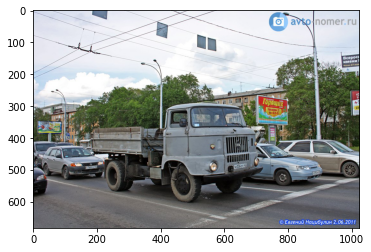

In [ ]:
f = os.path.join(PATH_TO_DATA, 'test/1024.jpg')
plt.imshow(plt.imread(f));

In [ ]:
tmp = pd.read_csv('submission_bidirect_resnet18_without_dup_greyscale_fin.csv', sep=';')
tmp.head()

,file_name,plates_string
0,test/999.bmp,Y519EB35
1,test/998.bmp,B117YB35
2,test/997.png,X580XX36 AY0205PO AH4402PH
3,test/996.bmp,T013AO35
4,test/995.jpg,P367XO96


In [ ]:
tmp.to_csv('submission_bidirect_resnet18_without_dup_greyscale_fin_true.csv', index=False)